In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot
from google.colab import drive
import os
import sys

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
py_dir = '/content/drive/MyDrive/Colab Notebooks/projekat/code'
os.chdir(py_dir)

sys.path.append(py_dir)

In [4]:
#import StoreSales # u ovom fajlu nalazi se kod koji kreira dataset, ali je on sacuvan u .csv fajlu kao sredjeni dataset
# dataset = StoreSales.create_dataset()
dataset = pd.read_csv('../data/formodel.csv')

In [5]:
dataset.drop(columns=['Unnamed: 0'],inplace=True)

In [6]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [7]:
dataset = dataset.set_index(['date','store_nbr','family'])

In [8]:
y_unstacked = dataset['sales'].unstack(['store_nbr','family'])

In [9]:
y_unstacked.isna().sum() # 1684 trening i 16 dodatnih NANs

store_nbr  family                    
1          AUTOMOTIVE                    16
           PERSONAL CARE                 16
           SEAFOOD                       16
           SCHOOL AND OFFICE SUPPLIES    16
           PRODUCE                       16
                                         ..
30         HOME APPLIANCES               16
           HOME AND KITCHEN II           16
           HOME AND KITCHEN I            16
           HARDWARE                      16
           PERSONAL CARE                 16
Length: 1782, dtype: int64

**Dodatno srediti holidays - za svaki date dodati da kolonu koja opisuje da li je datum u nekoj regiji proslavljan kao Local holiday, Event, National holiday, Additional, Work day**

In [10]:
date_store_holidays_final = dataset.reset_index().groupby(['date','store_nbr']).agg({'all_holidays':lambda x: ','.join(sorted(set(x)))}).pivot_table(index='date',columns='store_nbr',aggfunc=lambda x: ','.join(sorted(set(x)))) # 5. prodavnica slavi functation de santo domingo 2013-07-03!!!

**1. Priprema podataka iz holidays_events.csv**

In [11]:
def create_date_features(date_store_holidays_final):
  holidays_events = pd.read_csv('../data/holidays_events.csv')
  date_store_holidays_final['work_day'] = date_store_holidays_final.apply(lambda day:True if 'Work Day' in day.values else False,axis=1).astype('int')
  national_holidays = holidays_events.loc[(holidays_events['type']=='Holiday')&(holidays_events['locale']=='National'),:]['description'].drop_duplicates().tolist()

  local_holidays = holidays_events.loc[(holidays_events['locale']=='Local')&(holidays_events['type']=='Holiday'),:]['description'].drop_duplicates().tolist()

  events = ['Dia de la Madre', 'Mundial', 'Black Friday', 'Cyber Monday', 'Terremoto Manabi']

  date_store_holidays_final['national_holiday'] = date_store_holidays_final.apply(lambda day: True if any([ True for value in day.values if str(value).lstrip().rstrip() in national_holidays]) else False,axis=1).astype('int')

  date_store_holidays_final['local_holiday'] = date_store_holidays_final.apply(lambda day: True if any([ True for value in day.values if str(value).lstrip().rstrip() in local_holidays]) else False,axis=1).astype('int')

  date_store_holidays_final['event'] = date_store_holidays_final.apply(lambda day: True if any([ True for value in day.values if str(value).lstrip().rstrip() in events]) else False,axis=1).astype('int')

  date_store_holidays_final['weekend'] = (date_store_holidays_final.index.weekday>=5).astype('int')
  #date_store_holidays_final.drop(columns=['date','date_column'],inplace=True)
  date_store_holidays_final['year'] = date_store_holidays_final.index.year
  date_store_holidays_final['month'] = date_store_holidays_final.index.month
  date_store_holidays_final['day'] = date_store_holidays_final.index.day
  date_store_holidays_final['week'] = date_store_holidays_final.index.isocalendar().week
  date_store_holidays_final['season'] = date_store_holidays_final['month'].apply(lambda m:'dry' if m in [5,6,7,8,9,10] else 'wet')
  date_columns = date_store_holidays_final[['work_day','national_holiday','local_holiday','event','weekend','year','month','day','week','season']]
  date_columns = date_columns.reset_index()
  date_columns.columns = [''.join(col) for col in date_columns.columns]
  return date_columns

In [12]:
date_columns = create_date_features(date_store_holidays_final) # finalni sredjeni datumski podaci

In [265]:
date_columns

,date,work_day,national_holiday,local_holiday,event,weekend,year,month,day,week,season
0,2013-01-01,0,1,0,0,0,2013,1,1,1,wet
1,2013-01-02,1,0,0,0,0,2013,1,2,1,wet
2,2013-01-03,1,0,0,0,0,2013,1,3,1,wet
3,2013-01-04,1,0,0,0,0,2013,1,4,1,wet
4,2013-01-05,1,0,0,0,1,2013,1,5,1,wet
...,...,...,...,...,...,...,...,...,...,...,...
1695,2017-08-27,1,0,0,0,1,2017,8,27,34,dry
1696,2017-08-28,1,0,0,0,0,2017,8,28,35,dry
1697,2017-08-29,1,0,0,0,0,2017,8,29,35,dry
1698,2017-08-30,1,0,0,0,0,2017,8,30,35,dry


**2. Sada ćemo srediti transakcije za svaki date i store_no**

In [13]:
date_store_transactions = dataset['transactions_filled'].reset_index().groupby(['date','store_nbr']).agg({'transactions_filled':'mean'}).pivot_table(index='date',columns='store_nbr',values='transactions_filled')

In [14]:
date_store_transactions

store_nbr,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,2111.0,2358.0,3487.0,1922.0,1903.0,2143.0,1874.0,3250.0,2940.0,1293.0,...,4208.0,4886.0,4161.0,3397.0,2346.0,3077.0,1985.0,0.0,0.0,998.0
2013-01-03,1833.0,2033.0,3026.0,1551.0,1740.0,1795.0,1568.0,2904.0,2396.0,1157.0,...,3314.0,3438.0,3660.0,2887.0,1702.0,2307.0,1644.0,0.0,0.0,920.0
2013-01-04,1863.0,2066.0,3188.0,1596.0,1642.0,1679.0,1513.0,2962.0,1975.0,970.0,...,3630.0,3434.0,3915.0,2900.0,2016.0,2698.0,1786.0,0.0,0.0,794.0
2013-01-05,1509.0,2062.0,3623.0,1825.0,1643.0,2154.0,1599.0,3060.0,2604.0,1269.0,...,4331.0,4935.0,4764.0,4084.0,2562.0,3459.0,2068.0,0.0,0.0,949.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,2144.0,2314.0,4237.0,1771.0,1586.0,2105.0,2225.0,3774.0,2464.0,1054.0,...,5069.0,4339.0,5175.0,3645.0,4375.0,3063.0,1960.0,2255.0,1297.0,930.0
2017-08-28,2221.0,2474.0,4693.0,1967.0,1684.0,2242.0,2395.0,4125.0,2732.0,1188.0,...,5471.0,4844.0,5680.0,3935.0,4875.0,3557.0,2223.0,2255.0,1350.0,1078.0
2017-08-29,2555.0,2923.0,5074.0,2323.0,1982.0,2679.0,2595.0,4694.0,3077.0,1214.0,...,6367.0,5572.0,6586.0,4615.0,5643.0,4181.0,2607.0,2255.0,1707.0,1040.0


<Axes: xlabel='date'>

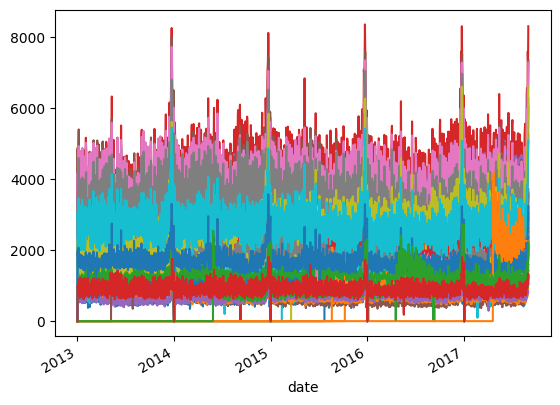

In [15]:
date_store_transactions.plot(legend=None)

**3. Priprema podataka za oil data. Dodata je kolona rolling mean, window=35 dana kako bi model mogao bolje da prati kretanje oil data.**

In [16]:
oil_data = dataset.reset_index().groupby('date').agg({'dcoilwtico':'mean'})
oil_data['rolling_mean'] =oil_data['dcoilwtico'].rolling(window=35).mean()
oil_data['rolling_mean'] = oil_data['rolling_mean'].fillna(93.14)
oil_data['rolling_mean_7'] = oil_data['dcoilwtico'].rolling(window=7).mean()
oil_data['rolling_mean_7'] = oil_data['rolling_mean_7'].fillna(method='bfill')
oil_data['rolling_mean_14'] = oil_data['dcoilwtico'].rolling(window=14).mean()
oil_data['rolling_mean_14'] = oil_data['rolling_mean_14'].fillna(method='bfill')

<Axes: xlabel='date'>

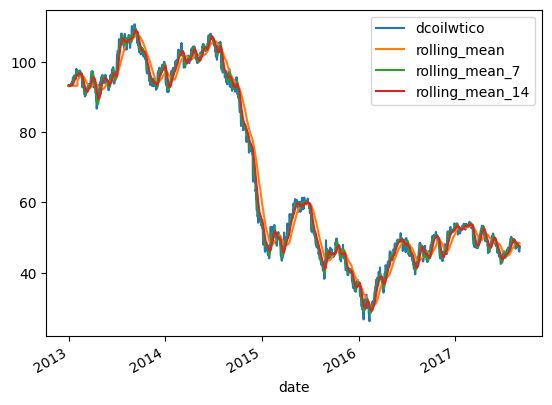

In [17]:
oil_data.plot()

<Axes: xlabel='date'>

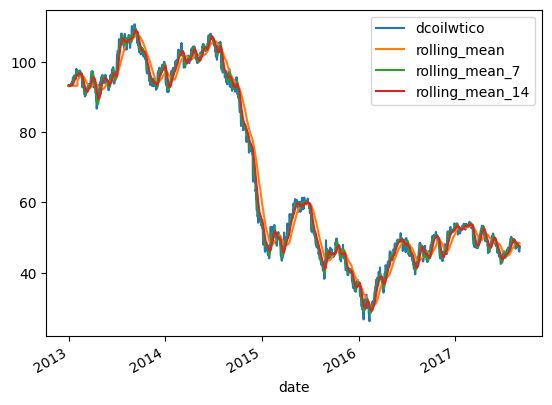

In [18]:
oil_data.plot()

4. **Onpromotion podaci za svaki proizvod, store_no i date**

In [19]:
promotions = pd.read_csv('../data/formodel.csv')[['date','store_nbr','family','onpromotion']] #onpromotion, type, cluster još nisam uvrstio.

In [20]:
promotions = promotions.set_index(['date','store_nbr','family']).unstack(['store_nbr','family'])  # na x osi su datumi na y store no i family a u poljima promotions

**5. Type & Cluster za svaku prodavnicu.**
- postoji 17 klastera i slične prodavnice pripadaju istom klasteru.
  clusters = {1,...,17}
- types = {A, B, C, D, E}


In [21]:
type_cluster = pd.read_csv('../data/formodel.csv')[['store_nbr','type','cluster']].drop_duplicates()

In [22]:
type_cluster=type_cluster.reset_index(drop=True)

In [23]:
type_cluster

,store_nbr,type,cluster
0,1,D,13
1,43,E,10
2,42,D,2
3,44,A,5
4,41,D,4
5,46,A,14
6,11,B,6
7,45,A,11
8,38,D,4
9,39,B,6


**Provera dimenzija dataframe-ova i spajanje.**

In [24]:
oil_data.shape # 1700,2
date_store_transactions.shape # 1700, 54
date_columns.shape # 1700,11
y_unstacked.shape # 1700,82
date_store_holidays_final.shape #1700,64

(1700, 64)

In [25]:
type_cluster.shape # tip i klaster za svaku prodavnicu

(54, 3)

In [26]:
oil_holidays = pd.merge(oil_data.reset_index(), date_columns,on=['date'])
oil_holidays = oil_holidays.set_index('date')

In [27]:
oil_holidays # ovo su neki opsti podaci

,dcoilwtico,rolling_mean,rolling_mean_7,rolling_mean_14,work_day,national_holiday,local_holiday,event,weekend,year,month,day,week,season
date,,,,,,,,,,,,,,
2013-01-01,93.14,93.140000,93.115714,93.355714,0,1,0,0,0,2013,1,1,1,wet
2013-01-02,93.14,93.140000,93.115714,93.355714,1,0,0,0,0,2013,1,2,1,wet
2013-01-03,92.97,93.140000,93.115714,93.355714,1,0,0,0,0,2013,1,3,1,wet
2013-01-04,93.12,93.140000,93.115714,93.355714,1,0,0,0,0,2013,1,4,1,wet
2013-01-05,93.12,93.140000,93.115714,93.355714,1,0,0,0,1,2013,1,5,1,wet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,47.65,48.542571,47.668571,47.748571,1,0,0,0,1,2017,8,27,34,dry
2017-08-28,46.40,48.548000,47.527143,47.663571,1,0,0,0,0,2017,8,28,35,dry
2017-08-29,46.46,48.510571,47.357143,47.584286,1,0,0,0,0,2017,8,29,35,dry


**1. PRODAVNICA**

**dostupni dataframe-ovi:**

oil_data.shape # 1700,2

date_store_transactions.shape # 1700, 54

date_columns.shape # 1700,11

y_unstacked.shape # 1700,82

date_store_holidays_final.shape #1700,64

type_cluster

oil_holidays

In [28]:
transactions1 = date_store_transactions.loc[:,[1]]
# oil_holidays data ide sve
#type_cluster # ne vidim zašto bi postojali podaci o tipu i klasteru prodavnice ako imamo samo jednu prodavnicu u trening i test setu.
# hajde onda da ne koristimo podatke o tipu i klasteru
transactions1.columns =['transactions'] # spojiti transakcije te prodavnice jer ih ima za sve datume
oil_holidays_transactions = pd.merge(oil_holidays, transactions1, left_index=True,right_index=True) # on ce sad da prepozna za te transakcije da su za neke 1 specificnih datuma one vece

**Transactions rolling means:**

In [29]:
oil_holidays_transactions['transactions_5'] = oil_holidays_transactions['transactions'].rolling(window=5).mean()
oil_holidays_transactions['transactions_7'] = oil_holidays_transactions['transactions'].rolling(window=7).mean()
oil_holidays_transactions['transactions_14'] = oil_holidays_transactions['transactions'].rolling(window=14).mean()
oil_holidays_transactions['transactions_5'] = oil_holidays_transactions['transactions_5'].fillna(method='bfill')
oil_holidays_transactions['transactions_7'] = oil_holidays_transactions['transactions_7'].fillna(method='bfill')
oil_holidays_transactions['transactions_14'] = oil_holidays_transactions['transactions_14'].fillna(method='bfill')

In [30]:
oil_holidays_transactions.columns

Index(['dcoilwtico', 'rolling_mean', 'rolling_mean_7', 'rolling_mean_14',
       'work_day', 'national_holiday', 'local_holiday', 'event', 'weekend',
       'year', 'month', 'day', 'week', 'season', 'transactions',
       'transactions_5', 'transactions_7', 'transactions_14'],
      dtype='object')

**grocery 1 sales, store 1**

In [31]:
dataset_res = dataset.reset_index()
sales_grocery1 = dataset_res.loc[(dataset_res['store_nbr']==1) & (dataset_res['family']=='GROCERY I'),['date','sales']]

In [32]:
dataset_res.loc[(dataset_res['store_nbr']==1),:]

,date,store_nbr,family,id,sales,onpromotion,dcoilwtico,city,state,type,cluster,all_holidays,transactions_filled
0,2013-01-01,1,AUTOMOTIVE,0,0.0,0,93.14,Quito,Pichincha,D,13,Primer dia del ano,0.0
1,2013-01-01,1,PERSONAL CARE,25,0.0,0,93.14,Quito,Pichincha,D,13,Primer dia del ano,0.0
2,2013-01-01,1,SEAFOOD,32,0.0,0,93.14,Quito,Pichincha,D,13,Primer dia del ano,0.0
3,2013-01-01,1,SCHOOL AND OFFICE SUPPLIES,31,0.0,0,93.14,Quito,Pichincha,D,13,Primer dia del ano,0.0
4,2013-01-01,1,PRODUCE,30,0.0,0,93.14,Quito,Pichincha,D,13,Primer dia del ano,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028306,2017-08-31,1,LAWN AND GARDEN,3027638,NaN,0,47.26,Quito,Pichincha,D,13,Work Day,3023.0
3028307,2017-08-31,1,LINGERIE,3027639,NaN,0,47.26,Quito,Pichincha,D,13,Work Day,3023.0
3028308,2017-08-31,1,"LIQUOR,WINE,BEER",3027640,NaN,2,47.26,Quito,Pichincha,D,13,Work Day,3023.0
3028309,2017-08-31,1,MAGAZINES,3027641,NaN,0,47.26,Quito,Pichincha,D,13,Work Day,3023.0


In [103]:
sales_grocery2 = dataset_res.loc[(dataset_res['store_nbr']==1) & (dataset_res['family']=='GROCERY II'),['date','sales']].set_index('date')

<Axes: xlabel='date'>

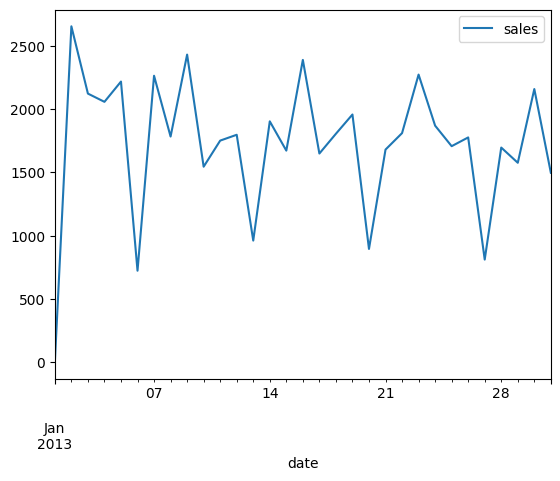

In [33]:
dataset_res.loc[(dataset_res['store_nbr']==1) & (dataset_res['family']=='GROCERY I'),['date','sales']].set_index('date').loc['2013-01'].plot()

In [34]:
sales_grocery1 = sales_grocery1.set_index('date') # y

<Axes: xlabel='date'>

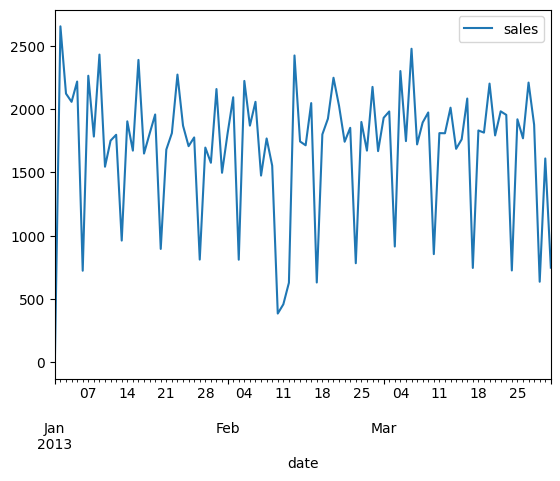

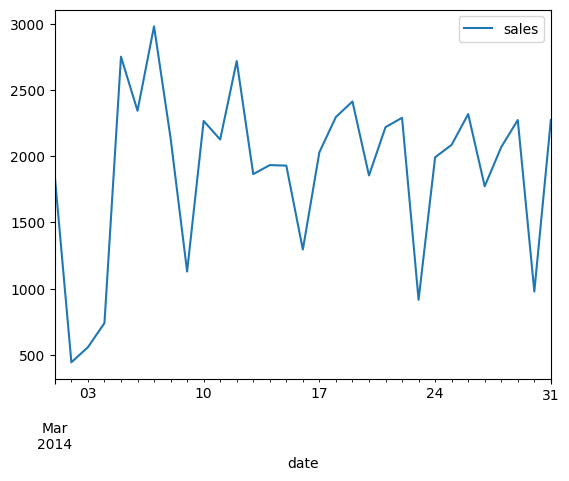

In [35]:
sales_grocery1.loc['2013-01':'2013-03'].plot()
sales_grocery1.loc['2014-03'].plot()

In [36]:
oil_holidays_transactions # X

,dcoilwtico,rolling_mean,rolling_mean_7,rolling_mean_14,work_day,national_holiday,local_holiday,event,weekend,year,month,day,week,season,transactions,transactions_5,transactions_7,transactions_14
date,,,,,,,,,,,,,,,,,,
2013-01-01,93.14,93.140000,93.115714,93.355714,0,1,0,0,0,2013,1,1,1,wet,0.0,1463.2,1377.571429,1479.214286
2013-01-02,93.14,93.140000,93.115714,93.355714,1,0,0,0,0,2013,1,2,1,wet,2111.0,1463.2,1377.571429,1479.214286
2013-01-03,92.97,93.140000,93.115714,93.355714,1,0,0,0,0,2013,1,3,1,wet,1833.0,1463.2,1377.571429,1479.214286
2013-01-04,93.12,93.140000,93.115714,93.355714,1,0,0,0,0,2013,1,4,1,wet,1863.0,1463.2,1377.571429,1479.214286
2013-01-05,93.12,93.140000,93.115714,93.355714,1,0,0,0,1,2013,1,5,1,wet,1509.0,1463.2,1377.571429,1479.214286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,47.65,48.542571,47.668571,47.748571,1,0,0,0,1,2017,8,27,34,dry,2144.0,1720.6,1787.857143,1674.642857
2017-08-28,46.40,48.548000,47.527143,47.663571,1,0,0,0,0,2017,8,28,35,dry,2221.0,1757.0,1842.857143,1709.500000
2017-08-29,46.46,48.510571,47.357143,47.584286,1,0,0,0,0,2017,8,29,35,dry,2555.0,1847.4,1911.285714,1771.071429


**Preprocesiranje**

In [37]:
oil_holidays_transactions.columns

Index(['dcoilwtico', 'rolling_mean', 'rolling_mean_7', 'rolling_mean_14',
       'work_day', 'national_holiday', 'local_holiday', 'event', 'weekend',
       'year', 'month', 'day', 'week', 'season', 'transactions',
       'transactions_5', 'transactions_7', 'transactions_14'],
      dtype='object')

In [38]:
oil_holidays_transactions['day_of_the_year'] = oil_holidays_transactions.index.dayofyear

In [39]:
oil_holidays_transactions.columns

Index(['dcoilwtico', 'rolling_mean', 'rolling_mean_7', 'rolling_mean_14',
       'work_day', 'national_holiday', 'local_holiday', 'event', 'weekend',
       'year', 'month', 'day', 'week', 'season', 'transactions',
       'transactions_5', 'transactions_7', 'transactions_14',
       'day_of_the_year'],
      dtype='object')

In [40]:
from sklearn.preprocessing import FunctionTransformer
# neka je period 12 meseci

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [41]:
copy_df = oil_holidays_transactions[['day','month','week','day_of_the_year']].copy()

copy_df['month_sin'] = sin_transformer(12).fit_transform(copy_df)['month']
copy_df['month_cos'] = cos_transformer(12).fit_transform(copy_df)['month']

copy_df['day_of_month_sin'] = sin_transformer(31).fit_transform(copy_df)['day']
copy_df['day_of_month_cos'] = cos_transformer(31).fit_transform(copy_df)['day']

copy_df['week_of_year_sin'] = sin_transformer(7).fit_transform(copy_df)['week']
copy_df['week_of_year_cos'] = cos_transformer(7).fit_transform(copy_df)['week']

copy_df['day_of_year_sin'] = sin_transformer(365).fit_transform(copy_df)['day_of_the_year']
copy_df['day_of_year_cos'] = cos_transformer(365).fit_transform(copy_df)['day_of_the_year']

In [42]:
oil_holidays_transactions = pd.merge(oil_holidays_transactions, copy_df[['month_sin','month_cos','day_of_month_sin','day_of_month_cos','week_of_year_sin','week_of_year_cos','day_of_year_sin','day_of_year_cos']], left_index=True, right_index=True)
oil_holidays_transactions= oil_holidays_transactions.drop(columns=['month','day','week','day_of_the_year'])

<Axes: xlabel='date'>

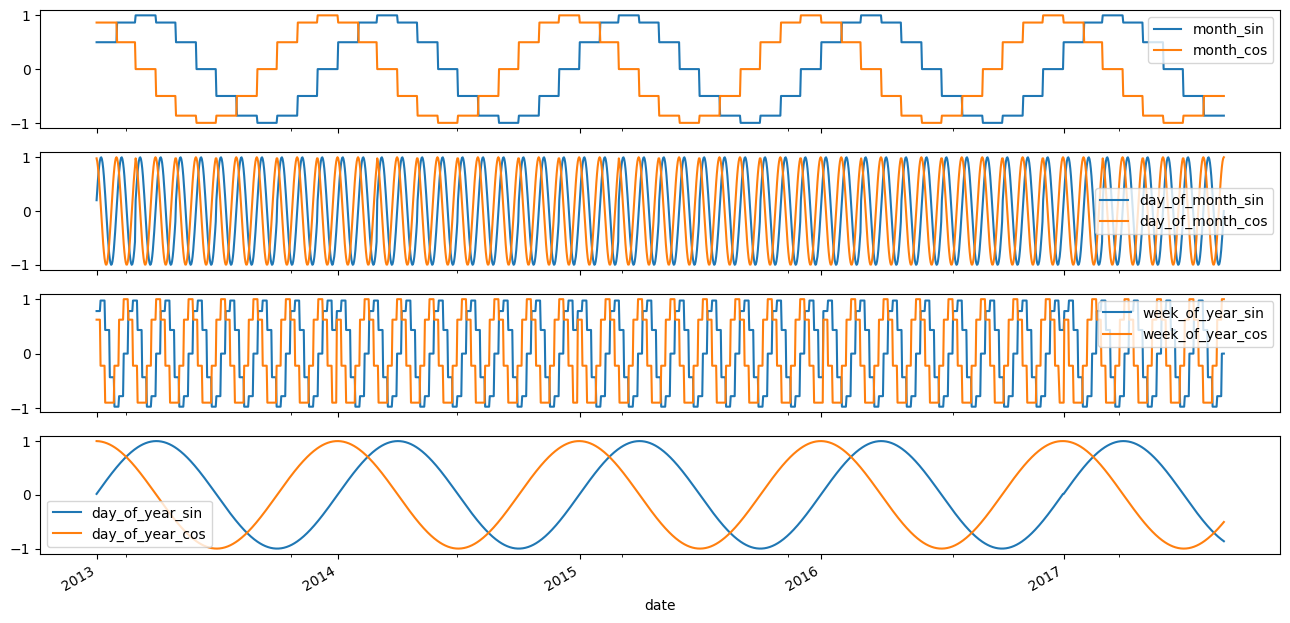

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(16,8))
oil_holidays_transactions[['month_sin','month_cos']].plot(ax=ax[0])
oil_holidays_transactions[['day_of_month_sin','day_of_month_cos']].plot(ax=ax[1])
oil_holidays_transactions[['week_of_year_sin','week_of_year_cos']].plot(ax=ax[2])
oil_holidays_transactions[['day_of_year_sin','day_of_year_cos']].plot(ax=ax[3])

**1.play matrix iz kojeg se kreiraju sekvence**

In [113]:
play_matrix = pd.merge(sales_grocery1, oil_holidays_transactions, left_index=True,right_index=True)

In [108]:
# play_matrix['sales_grocery2'] = sales_grocery2.values

In [114]:
play_matrix

,sales,dcoilwtico,rolling_mean,rolling_mean_7,rolling_mean_14,work_day,national_holiday,local_holiday,event,weekend,...,transactions_7,transactions_14,month_sin,month_cos,day_of_month_sin,day_of_month_cos,week_of_year_sin,week_of_year_cos,day_of_year_sin,day_of_year_cos
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,93.14,93.140000,93.115714,93.355714,0,1,0,0,0,...,1377.571429,1479.214286,0.500000,0.866025,2.012985e-01,0.979530,0.781831,0.62349,0.017213,0.999852
2013-01-02,2652.0,93.14,93.140000,93.115714,93.355714,1,0,0,0,0,...,1377.571429,1479.214286,0.500000,0.866025,3.943559e-01,0.918958,0.781831,0.62349,0.034422,0.999407
2013-01-03,2121.0,92.97,93.140000,93.115714,93.355714,1,0,0,0,0,...,1377.571429,1479.214286,0.500000,0.866025,5.712682e-01,0.820763,0.781831,0.62349,0.051620,0.998667
2013-01-04,2056.0,93.12,93.140000,93.115714,93.355714,1,0,0,0,0,...,1377.571429,1479.214286,0.500000,0.866025,7.247928e-01,0.688967,0.781831,0.62349,0.068802,0.997630
2013-01-05,2216.0,93.12,93.140000,93.115714,93.355714,1,0,0,0,1,...,1377.571429,1479.214286,0.500000,0.866025,8.486443e-01,0.528964,0.781831,0.62349,0.085965,0.996298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,NaN,47.65,48.542571,47.668571,47.748571,1,0,0,0,1,...,1787.857143,1674.642857,-0.866025,-0.500000,-7.247928e-01,0.688967,-0.781831,0.62349,-0.826354,-0.563151
2017-08-28,NaN,46.40,48.548000,47.527143,47.663571,1,0,0,0,0,...,1842.857143,1709.500000,-0.866025,-0.500000,-5.712682e-01,0.820763,-0.0,1.0,-0.835925,-0.548843
2017-08-29,NaN,46.46,48.510571,47.357143,47.584286,1,0,0,0,0,...,1911.285714,1771.071429,-0.866025,-0.500000,-3.943559e-01,0.918958,-0.0,1.0,-0.845249,-0.534373


**2. train test split iz play matrixa**

In [46]:
def split_data_train_test(dataframe, train_df_start_date, train_df_end_date, test_df_start_date, test_df_end_date):
    df_train = dataframe.loc[train_df_start_date:train_df_end_date]
    #print(df_train.shape)
    df_test = dataframe.loc[test_df_start_date: test_df_end_date]
    return df_train, df_test

X_train, X_test = split_data_train_test(play_matrix.drop(columns=['sales']),'2013-01-01','2017-08-15','2017-08-16','2017-08-31')
y_train, y_test = split_data_train_test(play_matrix['sales'], train_df_start_date='2013-01-01', train_df_end_date='2017-08-15',
                                        test_df_start_date='2017-08-16', test_df_end_date='2017-08-31')
print(f"X_train {X_train.shape}")
print(f"y_train {y_train.shape}")
print(f"X_test {X_test.shape}")
print(f"y_test {y_test.shape}")

X_train (1684, 23)
y_train (1684,)
X_test (16, 23)
y_test (16,)


**3. dodajemo validation set**

In [47]:
split_index = int(len(X_train)*0.9)
print(f"Split index: {split_index}")
all_data = pd.merge(X_train,y_train,left_index=True,right_index=True)
train_set = all_data[:split_index]
validation_set = all_data[split_index:]
train_set.shape, validation_set.shape

Split index: 1515


((1515, 24), (169, 24))

**4. pošto imamo u __getitem__ metodi to_numpy(), da bismo ubacili podatke u tenzore, potrebno je da ovde izvšim column transformer transformacije**

In [48]:
train_set.columns

Index(['dcoilwtico', 'rolling_mean', 'rolling_mean_7', 'rolling_mean_14',
       'work_day', 'national_holiday', 'local_holiday', 'event', 'weekend',
       'year', 'season', 'transactions', 'transactions_5', 'transactions_7',
       'transactions_14', 'month_sin', 'month_cos', 'day_of_month_sin',
       'day_of_month_cos', 'week_of_year_sin', 'week_of_year_cos',
       'day_of_year_sin', 'day_of_year_cos', 'sales'],
      dtype='object')

In [49]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder # 'month_sin', 'month_cos', 'day_of_month_sin', 'day_of_month_cos', 'week_of_year_sin', 'week_of_year_cos','day_of_year_sin', 'day_of_year_cos'
from sklearn.compose import ColumnTransformer

categorical_columns = ['year','season']
numeric_columns = ['dcoilwtico','transactions', 'month_sin', 'month_cos', 'day_of_month_sin', 'day_of_month_cos', 'week_of_year_sin', 'week_of_year_cos','day_of_year_sin', 'day_of_year_cos'
      ,'rolling_mean','transactions_5','transactions_7','transactions_14','rolling_mean_7','rolling_mean_14','sales' ] # 'rolling_mean','transactions_5','transactions_7','transactions_14','rolling_mean_7','rolling_mean_14'  mislim da ga rolling means zbunjuju?
binary_columns = ['work_day', 'national_holiday',
       'local_holiday', 'event', 'weekend']
#,'sales'
preprocessor = ColumnTransformer(
    transformers = [
        ('num', MinMaxScaler(), numeric_columns),
        ('cat',OneHotEncoder(),categorical_columns),
        ('bin','passthrough',binary_columns)
    ],
    remainder='passthrough'
)
#train_set, validation_set
train_indices = train_set.index
val_indices = validation_set.index

train_set_transformed = preprocessor.fit_transform(train_set)
validation_set_transformed = preprocessor.transform(validation_set)

In [50]:
#pd.DataFrame(validation_set_transformed)

In [51]:
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_columns = numeric_columns + list(cat_features) + binary_columns
train_preprocessed_df = pd.DataFrame(train_set_transformed, columns=all_columns)
train_preprocessed_df = train_preprocessed_df.set_index(train_indices)

validation_preprocessed_df = pd.DataFrame(validation_set_transformed,columns=all_columns)
validation_preprocessed_df = validation_preprocessed_df.set_index(val_indices)

In [52]:
train_preprocessed_df

,dcoilwtico,transactions,month_sin,month_cos,day_of_month_sin,day_of_month_cos,week_of_year_sin,week_of_year_cos,day_of_year_sin,day_of_year_cos,...,year_2015,year_2016,year_2017,season_dry,season_wet,work_day,national_holiday,local_holiday,event,weekend
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.792965,0.000000,0.750000,0.933013,0.600779,0.989739,0.900969,0.801938,0.508607,0.999926,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2013-01-02,0.792965,0.698313,0.750000,0.933013,0.697431,0.959375,0.900969,0.801938,0.517211,0.999704,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2013-01-03,0.790951,0.606351,0.750000,0.933013,0.786001,0.910151,0.900969,0.801938,0.525810,0.999333,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2013-01-04,0.792728,0.616275,0.750000,0.933013,0.862862,0.844083,0.900969,0.801938,0.534402,0.998815,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2013-01-05,0.792728,0.499173,0.750000,0.933013,0.924867,0.763876,0.900969,0.801938,0.542983,0.998149,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-23,0.335070,0.573272,0.933013,0.750000,0.000000,0.473324,0.900969,0.801938,0.900684,0.799087,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2017-02-24,0.329267,0.634469,0.933013,0.750000,0.005131,0.574623,0.900969,0.801938,0.905773,0.792145,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2017-02-25,0.329267,0.379094,0.933013,0.750000,0.030521,0.672813,0.900969,0.801938,0.910742,0.785117,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [53]:
train_set = train_preprocessed_df
validation_set = validation_preprocessed_df

In [54]:
train_set.shape, validation_set.shape

((1515, 29), (169, 29))

**4. kreiranje train i validation sekvenci**

In [55]:
from tqdm import tqdm
def create_sequences(input_data:pd.DataFrame, target_column, sequence_length):
  sequences = []
  data_size = len(input_data)
  for i in tqdm(range(data_size - sequence_length)):
    sequence = input_data[i:i+sequence_length]

    label_position = i + sequence_length
    label = input_data.iloc[label_position][target_column]

    sequences.append((sequence,label))
  return sequences

In [56]:
SEQUENCE_LENGTH = 7 #ranije 100
train_sequences = create_sequences(train_set,"sales",sequence_length=SEQUENCE_LENGTH)
validation_sequences = create_sequences(validation_set,"sales",sequence_length=SEQUENCE_LENGTH)

100%|██████████| 162/162 [00:00<00:00, 6503.17it/s]


In [57]:
#len(sequences) # ima 1693, sto je OK jer play_matrix ima 1700 observacija
train_sequences[0][1] # dataframe od 7 redova
#sequences[0][1] # vrednost koju je potrebno predvideti
#train_set.shape (1515, 29)

0.19658025372311086

**PyTorch Dataset**

In [58]:
import torch
import torch.nn as nn
import torch.utils
from torch.utils.data import Dataset

class SalesDataset(Dataset):
  def __init__(self, sequences):
    self.sequences = sequences

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, idx):
    sequence, label = self.sequences[idx]
    return dict(
        sequence=torch.Tensor(sequence.to_numpy()), # vraca dictionary sa tenzorom sekvence i labelu koju je potrebno predvideti
        label=torch.tensor(label).float()
    )

In [59]:
#!pip install pytorch-lightning
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class SalesDataModule(pl.LightningDataModule):
  def __init__(
      self, train_sequences, test_sequences, batch_size=8
  ):
    super().__init__()
    self.train_sequences = train_sequences
    self.test_sequences = test_sequences
    self.batch_size =  batch_size

  def setup(self): # konvertuje sekvence u sales dataset
    self.train_data = SalesDataset(self.train_sequences)
    self.test_data = SalesDataset(self.test_sequences)

  # data loader, validation loader and test loader, druga dva su jedno te isto

  def train_dataloader(self):
    return DataLoader(
        self.train_data,
        batch_size = self.batch_size,
        shuffle=False,
        num_workers=2  # faster load
    )

  def val_dataloader(self):
    return DataLoader(
        self.test_data,
        batch_size = 1,
        shuffle = False,
        num_workers = 1
    )


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 12.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [60]:
BATCH_SIZE = 7 # 5 # koliko sekvenci odjednom ulazi u model?

data_module = SalesDataModule(train_sequences, validation_sequences,batch_size=BATCH_SIZE)
data_module.setup() # kreira datasetove

In [61]:
train_data = SalesDataset(train_sequences)
#train_data['sequence']
for item in train_data:
   print(item['sequence'].shape)
   print(item['label'].shape)
   print(item['label'])   # scaled Store Sales
   break

torch.Size([7, 29])
torch.Size([])
tensor(0.1966)


**Model**

In [62]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
import torch.nn as nn
import torch.nn.init as init
class LSTM(nn.Module):
  def __init__(self,input_size, hidden_size, num_stacked_layers):

    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                        batch_first = True)
    for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                init.uniform_(param, -0.08, 0.08)  # Primer uniformne inicijalizacije

    #self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_stacked_layers,
    #                     batch_first=True)
    self.fc = nn.Linear(hidden_size,1) # lets make fully connected layer of our hidden

  def forward(self, x):
        x, _ = self.lstm(x)
        x = torch.relu(x)
        x = self.fc(x)
        return x


In [63]:
class RNN(nn.Module):
  def __init__(self,input_size,output_size,hidden_state,n_layers):
    super(RNN,self).__init__()
    self.num_layers = n_layers
    self.hidden_size = hidden_state
    self.rnn1 = nn.RNN(input_size, hidden_state, n_layers,batch_first=True)
    self.fc = nn.Linear(hidden_state,output_size)

  def forward(self,x):
    h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
    out,_ = self.rnn1(x,h0)
    out = out[:,-1,:]
    out = self.fc(out)
    return out

In [64]:
from torch import optim

In [65]:
#train_sequences, validation:sequences
for item in data_module.train_dataloader():
  x_batch = item['sequence']
  y_batch = item['label']
  print(item['sequence'].shape)
  print(item['label'].shape) # batch_size = 64, datapoints in seq = 70 no of features = 29
  print(item.keys())
  break

torch.Size([7, 7, 29])
torch.Size([7])
dict_keys(['sequence', 'label'])


In [66]:
model = LSTM(29,100,2)# 29, 4,2 najbolje sa 50 epocha
#model = RNN(input_size=29,output_size=1,hidden_dim=100,n_layers=2)
loss_function = nn.MSELoss()
learning_rate = 0.001 # 0.001
N_EPOCHS = 50 # 17 95 je super

#num_epochs = 10
optimizer = torch.optim.AdamW(model.parameters(),
                             lr = learning_rate)

In [67]:
model.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-0.0569, -0.0593,  0.0355,  ..., -0.0782, -0.0468,  0.0066],
                      [ 0.0530, -0.0140, -0.0112,  ...,  0.0146,  0.0791, -0.0129],
                      [-0.0758,  0.0096,  0.0553,  ...,  0.0318,  0.0088,  0.0141],
                      ...,
                      [ 0.0795, -0.0190,  0.0353,  ..., -0.0272,  0.0488, -0.0109],
                      [-0.0785,  0.0680, -0.0614,  ..., -0.0108,  0.0458, -0.0110],
                      [-0.0279, -0.0463, -0.0212,  ...,  0.0494,  0.0186,  0.0355]])),
             ('lstm.weight_hh_l0',
              tensor([[ 7.5700e-02, -3.5053e-03,  5.2083e-02,  ...,  7.3043e-03,
                       -7.5287e-02, -5.9168e-02],
                      [-2.3911e-03, -7.6616e-02, -2.0365e-03,  ..., -1.8735e-02,
                       -1.5218e-02,  3.2961e-02],
                      [ 7.5421e-02,  3.4580e-02,  6.4527e-02,  ...,  4.9586e-02,
                       -5.2139e-02,  6.1090e-03],
   

In [68]:
def train_one_epoch():
  model.train(True)
  running_loss = 0.0
  counter = 0
  for item in data_module.train_dataloader(): # izbacuje ih dokle god ih ima
    x_batch = item['sequence']
    y_batch = item['label']
    # print(x_batch.shape)
    # print(y_batch.shape)
    output = model(x_batch)  # tensor of size [64, 70, 29], batch size je 64
    loss = loss_function(output, y_batch)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if counter%20 == 0 :
      avg_loss = running_loss/10
      print("Batch{0}, Loss:{1:.5f}".format(counter+1,avg_loss))
      running_loss = 0.0
    counter +=1

In [69]:
def validate_one_epoch(): # prolazi kroz sve batcheve u validation dataloaderu!!!
  model.train(False)
  running_loss = 0.0
  for item in data_module.val_dataloader(): # izbacuje ih dokle god ih ima
    x_batch = item['sequence']
    y_batch = item['label']
    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output,y_batch)
      running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(data_module.val_dataloader())
  print("Val Loss: {0:.5f}".format(avg_loss_across_batches))
  print("*************************************************")


In [70]:
len(data_module.val_dataloader()) # 162
len(data_module.train_dataloader()) # 216

216

In [71]:
counter = 0
for epoch in range(N_EPOCHS): # N_EPOCHS
  print(f"Epoch: {counter+1}")
  train_one_epoch()
  validate_one_epoch() # batch_size = 64 sekvence * br_batches = 23 ==> 1472 sekvence , 50 iteracija, 60, 70,80, 90, 100, 110, 120, 130, 140,150, 160, 170,180,190,200,210,220,230,240,250,260,270,280,300
  counter += 1 # 330, 370,410, 460,510, 610, 710

Epoch: 1
Batch1, Loss:0.00122
Batch21, Loss:0.00950
Batch41, Loss:0.00663
Batch61, Loss:0.01428
Batch81, Loss:0.00897
Batch101, Loss:0.00873
Batch121, Loss:0.01344
Batch141, Loss:0.01049
Batch161, Loss:0.01716
Batch181, Loss:0.03007
Batch201, Loss:0.01119
Val Loss: 0.00734
*************************************************
Epoch: 2
Batch1, Loss:0.00157
Batch21, Loss:0.01019
Batch41, Loss:0.00593
Batch61, Loss:0.01368
Batch81, Loss:0.00813
Batch101, Loss:0.00862
Batch121, Loss:0.01245
Batch141, Loss:0.01012
Batch161, Loss:0.01687
Batch181, Loss:0.02772
Batch201, Loss:0.01133
Val Loss: 0.00762
*************************************************
Epoch: 3
Batch1, Loss:0.00234
Batch21, Loss:0.01294
Batch41, Loss:0.00592
Batch61, Loss:0.01381
Batch81, Loss:0.00800
Batch101, Loss:0.00866
Batch121, Loss:0.01226
Batch141, Loss:0.01004
Batch161, Loss:0.01688
Batch181, Loss:0.02734
Batch201, Loss:0.01129
Val Loss: 0.00761
*************************************************
Epoch: 4
Batch1, Loss:0.0019

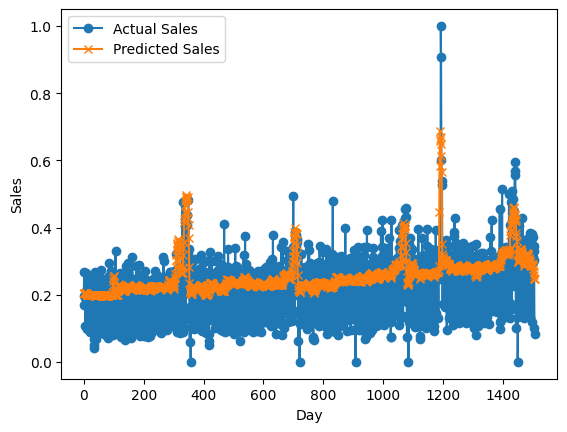

In [72]:
#train_sequences[0][0]
all_predictions = []
real_values = []
for item in data_module.train_dataloader(): # izbacuje ih dokle god ih ima
    x_batch = item['sequence']
    y_batch = item['label']
    real_values.extend(y_batch)
    #print(x_batch.shape)
    #print(y_batch.shape)
    with torch.no_grad():
      predictions = model(x_batch)
      # print("Jedan batch")
      # print(len(predictions))
      all_predictions.extend(predictions[:,-1,:].numpy())
      #print(len(predictions)) # 64
      #break
all_predictions = np.array(all_predictions)#.clip(0.)
real_values = np.array(real_values)
#len(real_values) - 1394
#len(all_predictions) - 1394, ali ne zaboravi break da izbrises
# poslednjih 70 observacija nemaju predikciju njih cemo koristiti za predikciju prve testne instance
# with torch.no_grad():
#   predicted = model(train_sequences[0][0]).numpy()
plt.plot(real_values,label="Actual Sales",marker='o')
plt.plot(all_predictions,label="Predicted Sales", marker='x')

plt.xlabel("Day")
plt.ylabel("Sales")
plt.legend()
plt.show()

In [73]:
from sklearn.metrics import mean_squared_error
results_df = pd.DataFrame(all_predictions,columns=['Predicted'])
results_df['Actual'] = real_values
mean_squared_error(results_df['Actual'],results_df['Predicted'])

0.006045769

In [74]:
results_df[0:14] # drugi batch lose predvidja, 4 batch pakaooo

,Predicted,Actual
0,0.202355,0.196580
1,0.204129,0.267954
2,0.204308,0.170325
3,0.204089,0.193050
4,0.204403,0.198125
5,0.204785,0.106012
6,0.204707,0.209818
7,0.205419,0.184335
8,0.204134,0.263320
9,0.202672,0.181798


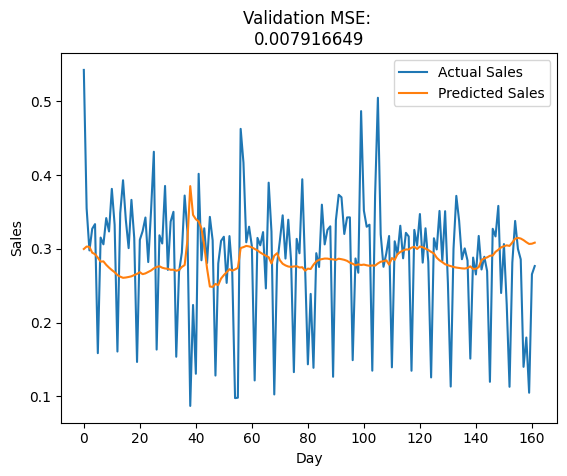

In [75]:
#train_sequences[0][0]
all_predictions = []
real_values = []
for item in data_module.val_dataloader(): # izbacuje ih dokle god ih ima
    x_batch = item['sequence']
    y_batch = item['label']
    real_values.extend(y_batch)
    #print(x_batch.shape)
    #print(y_batch.shape)
    with torch.no_grad():
      predictions = model(x_batch)
      all_predictions.extend(predictions[:,-1,:].numpy())
      #print(len(predictions)) # 64
      #break
all_predictions = np.array(all_predictions)
real_values = np.array(real_values)
#len(real_values) - 1394
#len(all_predictions) - 1394, ali ne zaboravi break da izbrises
# poslednjih 70 observacija nemaju predikciju njih cemo koristiti za predikciju prve testne instance
# with torch.no_grad():
#   predicted = model(train_sequences[0][0]).numpy()
plt.plot(real_values,label="Actual Sales")
plt.plot(all_predictions,label="Predicted Sales")
plt.xlabel("Day")
plt.ylabel("Sales")
plt.title("Validation MSE: \n"+str(mean_squared_error(real_values,all_predictions)))
plt.legend()
plt.show()

**LSTM with keras**

In [76]:
# train_set
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 7 # duzina ulazne sekvence
#n_features =1

In [77]:
generator = TimeseriesGenerator(data=train_set,
                                targets=train_set['sales'],
                                length=n_input,
                                batch_size=7
                                )

In [78]:
xg, yg = generator[0]
xg.shape, yg.shape
# generator - type is keras.src.preprocessing.sequence.TimeseriesGenerator
len(generator) # velicina generatora je 216 kombinacija
# 216 je no of batches gde svaki batch ima 7 sekvenci, a sekvenca ima 7 observacija na osnovu
# kojih predvidja vrednost sales za osmu. Za osmo predvidjanje mi ne posmatramo vrednost ostalih atributa za tu observaciju

216

In [79]:
#xg.shape, yg.sh
xg[0,:,:].shape #prva sekvenca od 7 dana i 29 kolona
#pd.DataFrame(xg[3,:,:]) # prva sekvenca treba da predvidi 0.1111
#train_set[7:15]['sales'] # ove brojeve predvidja prvih 7 sekvenci 7 batches, sto je ok, provereno ovim kodom kolona = yg
#yg[0] # prvi batch prve sekvence predvidja broj 0.1111
#yg #[0.11111111, 0.11111111, 0.11111111, 0.16666667, 0.11111111,0.11111111, 0.11111111]

(7, 29)

In [80]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model2 = Sequential()
model2.add(LSTM(100,activation='relu',batch_input_shape=(7,7,29), return_sequences=True)) #relu, True jer ovaj sloj svoj izlaz prosledjuje drugom lstm sloju
model2.add(LSTM(100,activation='relu')) # nije naveden batch input shape, on koristi itlat iz prethodnog LSTM sloja kao ulaz
# model2.add(Dense(25))
model2.add(Dense(1)) # jedan izlaz za svaku sekvencu,
model2.compile(optimizer='adam',loss='mse')

In [81]:
model2.fit(generator,epochs=30,batch_size=7, shuffle=False) # length generator objekta je 216, znaci ima 216 kombinacija od po 7 sekvenci

Epoch 1/30
216/216 [==============================] - 5s 10ms/step - loss: 0.0077
Epoch 2/30
216/216 [==============================] - 2s 10ms/step - loss: 0.0066
Epoch 3/30
216/216 [==============================] - 2s 10ms/step - loss: 0.0061
Epoch 4/30
216/216 [==============================] - 3s 14ms/step - loss: 0.0056
Epoch 5/30
216/216 [==============================] - 2s 10ms/step - loss: 0.0060
Epoch 6/30
216/216 [==============================] - 2s 10ms/step - loss: 0.0055
Epoch 7/30
216/216 [==============================] - 2s 10ms/step - loss: 0.0043
Epoch 8/30
216/216 [==============================] - 2s 10ms/step - loss: 0.0034
Epoch 9/30
216/216 [==============================] - 3s 14ms/step - loss: 0.0035
Epoch 10/30
216/216 [==============================] - 3s 15ms/step - loss: 0.0037
Epoch 11/30
216/216 [==============================] - 2s 10ms/step - loss: 0.0042
Epoch 12/30
216/216 [==============================] - 2s 10ms/step - loss: 0.0039
Epoch 13/30
2

Text(0, 0.5, 'MSE')

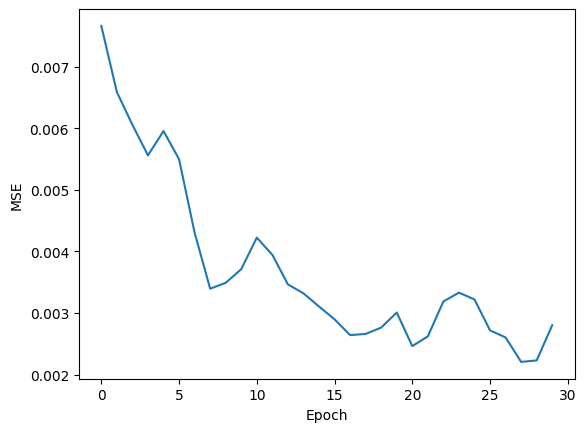

In [82]:
import matplotlib.pyplot as plt
loss_per_epoch = model2.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("MSE")

In [83]:
predictions = model2.predict(generator)

216/216 [==============================] - 2s 6ms/step


In [84]:
actual_sales = train_set['sales']

In [85]:
# time_steps = range(len(actual_sales))
len(predictions) # 1508
len(actual_sales) # 1515
#predictions
zeros = np.array([0]*7)
results_keras=pd.concat([pd.DataFrame(zeros),pd.DataFrame(predictions)],axis=0)
results_keras.columns=['Predicted']
#actual_sales.values
results_keras['Actual'] = actual_sales.values
train_mse = np.mean((results_keras['Actual'][7:] - results_keras['Predicted'][7:])**2)

In [86]:
time_steps_actual = range(7,len(actual_sales)) # 7 do 1515

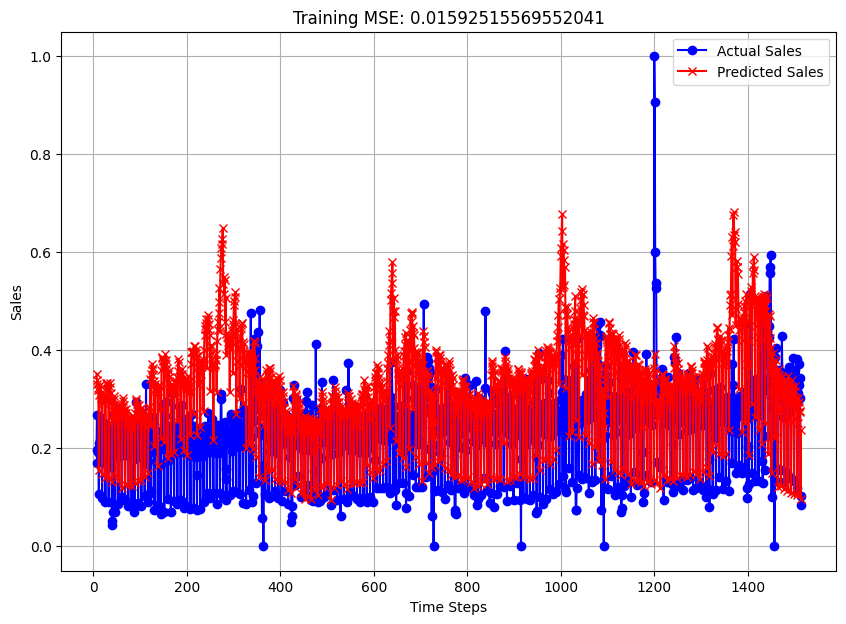

In [299]:
plt.figure(figsize=(10, 7))
plt.plot(time_steps_actual, actual_sales[7:], marker='o', label='Actual Sales', color='b')
plt.plot(time_steps_actual, predictions.clip(0.), marker='x', label='Predicted Sales', color='r')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time Steps')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.title(f"Training MSE: {train_mse}")
plt.show()

**Predikcija - poslednjih 7 instanci koriste se za predvidjanje prve instance u test setu**

In [88]:
test_predictions = [] # prazna lista za test predikcije
real_values = []
#1. poslednjih sedam predvidja prvu testnu instancu,
#2. poslednjih 6 i prvi test predvidjaju drugi test
#3. poslednjih 5 i prva 2 testa predvidjaju 3. test
# ... spojimo poslednjih 7 iz treninga sa validaton setom i tako ih predvidjamo
test_data = pd.concat([train_set[-7:],validation_set],axis=0)
#train_set.shape, validation_set.shape

In [89]:
test_generator = TimeseriesGenerator(data=test_data,
                                targets=test_data['sales'],
                                length=n_input, # n input je takodje 7
                                batch_size=1
                                )


In [90]:
test_generator[1][1]

array([0.40022063])

In [91]:
for item in test_generator:
  x_test_data, y_test_data =  item
  #pd.DataFrame(x_test_data.reshape(7,29)) - ovde je 7 redova i 29 kolona koji predvidjaju y1 value
  #x_test_data.shape # ovo nam je super za predikciju
  #y_test_data.shape
  predicted_value = model2.predict(x_test_data)[0]
  test_predictions.append(predicted_value)
  #print(y_test_data[0])
  real_values.append(float(y_test_data[0]))

1/1 [==============================] - 0s 28ms/step


In [92]:
results_dataframe = pd.DataFrame(test_predictions,columns=['Test values'])
results_dataframe['Real values'] = real_values

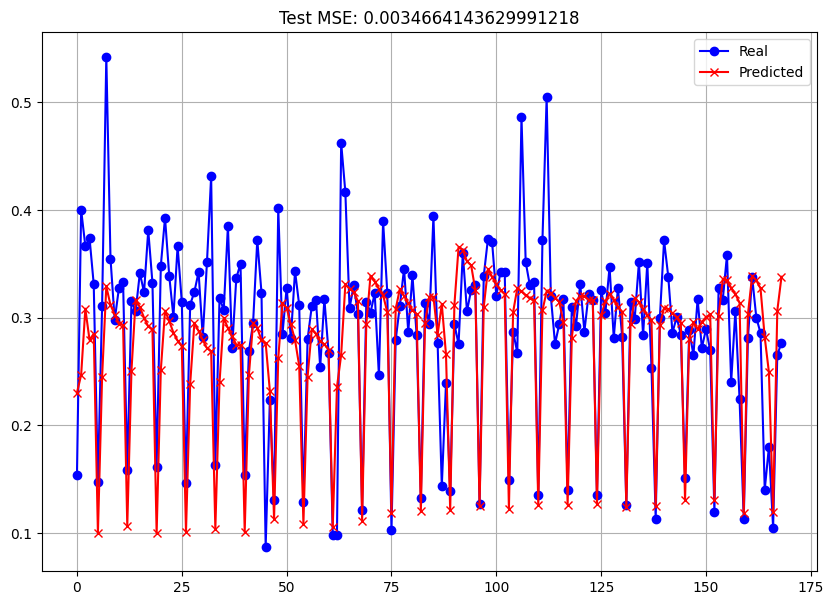

In [93]:
x = results_dataframe.index
plt.figure(figsize=(10,7))
plt.plot(x,results_dataframe['Real values'].clip(0.),marker='o', color='b',label="Real")
plt.plot(x, results_dataframe['Test values'].clip(0.),marker='x', color='r',label="Predicted")
mse = np.mean((results_dataframe['Real values'] - results_dataframe['Test values'])**2)
plt.title(f"Test MSE: {mse}")
plt.grid(True)
plt.legend()
plt.show()

**Za 1 prodavnicu za bilo koji food family radi predikciju**

In [256]:
def split_data_train_test(dataframe, train_df_start_date, train_df_end_date, test_df_start_date, test_df_end_date):
    df_train = dataframe.loc[train_df_start_date:train_df_end_date]
    #print(df_train.shape)
    df_test = dataframe.loc[test_df_start_date: test_df_end_date]
    return df_train, df_test


def create_data(oil_holidays_transactions, dataset, store_no, store_family):
  """
    oil_holdiays_transactions - X matrica za prodavnicu 1
    dataset - podaci o prodaji za sve prodavnice i tipove proizvoda
    store_no - broj prodavnice za koju želimo da radimo predikciju
    store_family - tip proizvoda za koji se radi predikcija
  """
  dataset_res = dataset.reset_index()
  target_data = dataset_res.loc[(dataset_res['store_nbr']==store_no) & (dataset_res['family']==store_family),['date','sales']].set_index('date')
  play_matrix = pd.merge(target_data, oil_holidays_transactions, left_index=True,right_index=True)

  #2. kreiranje train, validation, test splita

  X_train, X_test = split_data_train_test(play_matrix.drop(columns=['sales']),'2013-01-01','2017-08-15','2017-08-16','2017-08-31')
  y_train, y_test = split_data_train_test(play_matrix['sales'], train_df_start_date='2013-01-01', train_df_end_date='2017-08-15',
                                        test_df_start_date='2017-08-16', test_df_end_date='2017-08-31')

  split_index = int(len(X_train)*0.9)
  #print(f"Split index: {split_index}")
  all_data = pd.merge(X_train,y_train,left_index=True,right_index=True)
  train_set = all_data[:split_index]
  validation_set = all_data[split_index:]
  return train_set, validation_set

In [257]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder # 'month_sin', 'month_cos', 'day_of_month_sin', 'day_of_month_cos', 'week_of_year_sin', 'week_of_year_cos','day_of_year_sin', 'day_of_year_cos'
from sklearn.compose import ColumnTransformer
def preprocess_data(train_set, validation_set):
  categorical_columns = ['year','season']
  numeric_columns = ['dcoilwtico','transactions', 'month_sin', 'month_cos', 'day_of_month_sin', 'day_of_month_cos', 'week_of_year_sin', 'week_of_year_cos','day_of_year_sin', 'day_of_year_cos'
      ,'rolling_mean','transactions_5','transactions_7','transactions_14','rolling_mean_7','rolling_mean_14','sales' ] # 'rolling_mean','transactions_5','transactions_7','transactions_14','rolling_mean_7','rolling_mean_14'  mislim da ga rolling means zbunjuju?
  binary_columns = ['work_day', 'national_holiday',
       'local_holiday', 'event', 'weekend']
  preprocessor = ColumnTransformer(
    transformers = [
        ('num', MinMaxScaler(), numeric_columns),
        ('cat',OneHotEncoder(),categorical_columns),
        ('bin','passthrough',binary_columns)
    ],
    remainder='passthrough'
  )
  #train_set, validation_set
  train_indices = train_set.index
  val_indices = validation_set.index

  train_set_transformed = preprocessor.fit_transform(train_set)
  validation_set_transformed = preprocessor.transform(validation_set)

  # dataframeovi iz kolumn transformera
  cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
  all_columns = numeric_columns + list(cat_features) + binary_columns
  train_preprocessed_df = pd.DataFrame(train_set_transformed, columns=all_columns)
  train_preprocessed_df = train_preprocessed_df.set_index(train_indices)

  validation_preprocessed_df = pd.DataFrame(validation_set_transformed,columns=all_columns)
  validation_preprocessed_df = validation_preprocessed_df.set_index(val_indices)

  train_set = train_preprocessed_df
  validation_set = validation_preprocessed_df
  return train_set, validation_set

In [259]:
from keras.preprocessing.sequence import TimeseriesGenerator
def get_train_generator(train_set,n_input, batch_size):
  n_input = n_input # duzina ulazne sekvence
  #n_features =1
  generator = TimeseriesGenerator(data=train_set,
                                targets=train_set['sales'],
                                length=n_input,
                                batch_size=batch_size
                                )
  return generator
generator = get_train_generator(train_set,7,7)

In [258]:
def prepare_data_for_model(oil_holidays_transactions,dataset,store_no,family_product, batch_size, time_sequence):
  train_set, validation_set = create_data(oil_holidays_transactions, dataset, store_no,family_product)
  train_set, validation_set = preprocess_data(train_set, validation_set)
  generator = get_train_generator(train_set,time_sequence,batch_size)
  return generator, train_set, validation_set

In [260]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
import matplotlib.pyplot as plt
from keras import regularizers



def train_model(generator,epochs, hidden_units, activation,sequence_length, batch_size,optimizer,loss):
  model2 = Sequential()
  model2.add(LSTM(hidden_units,activation=activation,batch_input_shape=(batch_size,sequence_length,29), return_sequences=True)) #relu, True jer ovaj sloj svoj izlaz prosledjuje drugom lstm sloju
  model2.add(Dropout(0.3))
  model2.add(LSTM(hidden_units,activation=activation,batch_input_shape=(batch_size,sequence_length,29), return_sequences=True)) # nije naveden batch input shape, on koristi itlat iz prethodnog LSTM sloja kao ulaz
  model2.add(Dropout(0.3))
  model2.add(LSTM(hidden_units,activation=activation,batch_input_shape=(batch_size,sequence_length,29)))
  model2.add(Dense(1)) # jedan izlaz za svaku sekvencu,
  model2.compile(optimizer=optimizer,loss=loss)
  model2.fit(generator,epochs=epochs,batch_size=batch_size, shuffle=False) # length generator objekta je 216, znaci ima 216 kombinacija od po 7 sekvenci
  return model2

def plot_mse(model):
  loss_per_epoch = model.history.history['loss']
  plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
  plt.xlabel("Epoch")
  plt.ylabel("MSE")
  plt.title("MSE during each epoch")

def predict_and_plot_train_data(trained_model, train_set, generator):
  predictions = trained_model.predict(generator)
  # plot actual vs predictedza trening
  actual_sales = train_set['sales']
  # time_steps = range(len(actual_sales))
  len(predictions) # 1508
  len(actual_sales) # 1515
  #predictions
  zeros = np.array([0]*7)
  results_keras=pd.concat([pd.DataFrame(zeros),pd.DataFrame(predictions)],axis=0)
  results_keras.columns=['Predicted']
  #actual_sales.values
  results_keras['Actual'] = actual_sales.values
  train_mse = np.mean((results_keras['Actual'][7:] - results_keras['Predicted'][7:])**2)
  time_steps_actual = range(7,len(actual_sales)) # 7 do 1515
  plt.figure(figsize=(10, 7))
  plt.plot(time_steps_actual, actual_sales[7:], marker='o', label='Actual Sales', color='b')
  plt.plot(time_steps_actual, predictions.clip(0.), marker='x', label='Predicted Sales', color='r')
  plt.title('Actual vs Predicted Sales')
  plt.xlabel('Time Steps')
  plt.ylabel('Sales')
  plt.legend()
  plt.grid(True)
  plt.title(f"Training MSE: {train_mse}")
  plt.show()

def predict_and_plot_test_data(model, train_set,validation_set, sequence_length):
  test_predictions = [] # prazna lista za test predikcije
  real_values = []
  #1. poslednjih sedam predvidja prvu testnu instancu,
  #2. poslednjih 6 i prvi test predvidjaju drugi test
  #3. poslednjih 5 i prva 2 testa predvidjaju 3. test
  # ... spojimo poslednjih 7 iz treninga sa validaton setom i tako ih predvidjamo
  test_data = pd.concat([train_set[-7:],validation_set],axis=0)
  #train_set.shape, validation_set.shape
  test_generator = TimeseriesGenerator(data=test_data,
                                targets=test_data['sales'],
                                length=sequence_length, # n input je takodje 7
                                batch_size=1
                                )
  for item in test_generator:
    x_test_data, y_test_data =  item
    #pd.DataFrame(x_test_data.reshape(7,29)) - ovde je 7 redova i 29 kolona koji predvidjaju y1 value
    #x_test_data.shape # ovo nam je super za predikciju
    #y_test_data.shape
    predicted_value = model.predict(x_test_data)[0]
    test_predictions.append(predicted_value)
    #print(y_test_data[0])
    real_values.append(float(y_test_data[0]))

  results_dataframe = pd.DataFrame(test_predictions,columns=['Test values'])
  results_dataframe['Real values'] = real_values
  x = results_dataframe.index
  plt.figure(figsize=(10,7))
  plt.plot(x,results_dataframe['Real values'].clip(0.),marker='o', color='b',label="Real")
  plt.plot(x, results_dataframe['Test values'].clip(0.),marker='x', color='r',label="Predicted")
  mse = np.mean((results_dataframe['Real values'] - results_dataframe['Test values'])**2)
  plt.title(f"Test MSE: {mse}")
  plt.grid(True)
  plt.legend()
  plt.show()

Epoch 1/200
216/216 [==============================] - 11s 16ms/step - loss: 0.0144
Epoch 2/200
216/216 [==============================] - 3s 16ms/step - loss: 0.0135
Epoch 3/200
216/216 [==============================] - 4s 18ms/step - loss: 0.0137
Epoch 4/200
216/216 [==============================] - 4s 21ms/step - loss: 0.0133
Epoch 5/200
216/216 [==============================] - 3s 16ms/step - loss: 0.0132
Epoch 6/200
216/216 [==============================] - 3s 16ms/step - loss: 0.0131
Epoch 7/200
216/216 [==============================] - 5s 21ms/step - loss: 0.0126
Epoch 8/200
216/216 [==============================] - 4s 21ms/step - loss: 0.0124
Epoch 9/200
216/216 [==============================] - 3s 16ms/step - loss: 0.0121
Epoch 10/200
216/216 [==============================] - 4s 16ms/step - loss: 0.0120
Epoch 11/200
216/216 [==============================] - 5s 23ms/step - loss: 0.0116
Epoch 12/200
216/216 [==============================] - 4s 19ms/step - loss: 0.0115


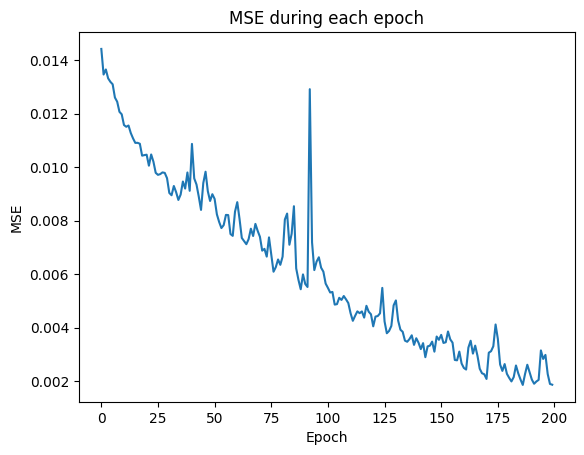

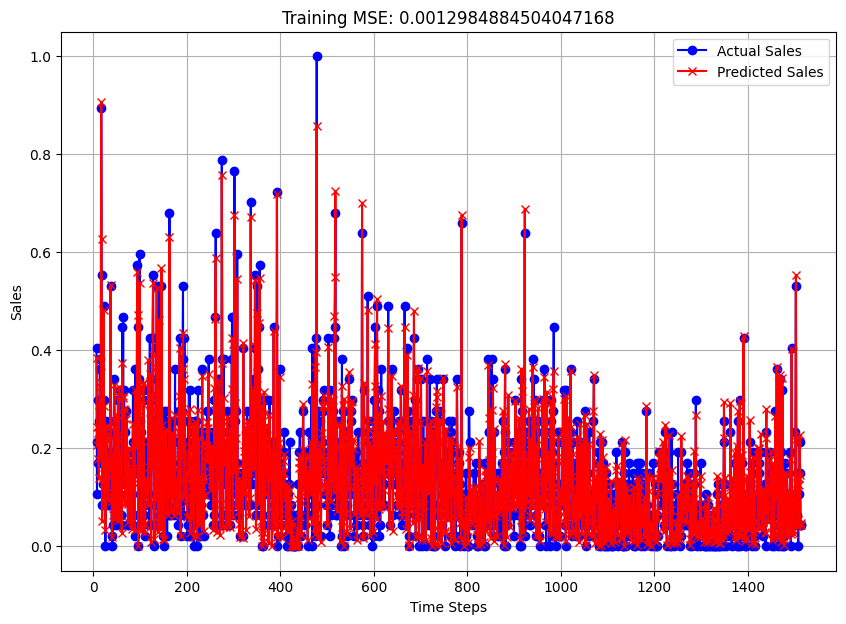

1/1 [==============================] - 0s 26ms/step


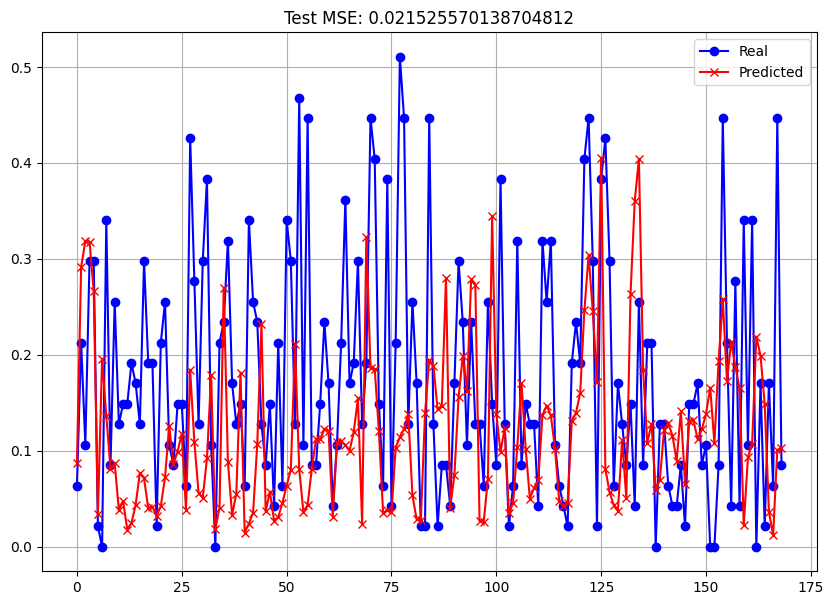

In [264]:
train_generator, train_set,validation_set = prepare_data_for_model(oil_holidays_transactions,dataset,1,'LINGERIE',7,7) # POZIV KLJUCNE METODE
# ovde moze i da se ostavi prostor za optimizaciju hiperparametara.
trained_model = train_model(train_generator,200,100, 'relu',7,7,'adam','mse') # treba ti 200+ iteracija, niakko smanjivati no of hidden layers
plot_mse(trained_model)
predict_and_plot_train_data(trained_model, train_set, train_generator)
predict_and_plot_test_data(trained_model, train_set,validation_set,7)

In [175]:
# Dropout(0.2): Primjenjuje dropout regularizaciju sa stopom od 0.2 nakon svakog dense sloja.
# Dropout pomaže u sprečavanju preprilagođavanja tako što nasumično postavlja deo ulaznih jedinica na 0 tokom treninga.